In [1]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import time

2024-04-23 05:06:25.499718: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 05:06:25.501765: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 05:06:25.543354: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 05:06:26.206725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Hyperparameters
num_epochs = 10
learning_rate = 5e-5
batch_size = 16
num_trains = 15
label_modularity = "Cat2"
#bert-base-uncased, bert-large-cased
name_model = "bert-base-uncased"

crop_categories = True

In [3]:
#Get documents saved in new categories and their labels
train_filename = '2Dataset/train_40k.csv'
validation_filename = '2Dataset/val_10k.csv'

train_data = pd.read_csv(train_filename)
validation_data = pd.read_csv(validation_filename)

In [4]:
if crop_categories:
    category_list = ['dogs', 'hair care', 'cats', 'fish aquatic pets', 'fresh flowers live indoor plants', 'health care', 'diapering', 'strollers', 'medical supplies equipment', 'safety']

    train_data = train_data[train_data['Cat2'].isin(category_list)]
    validation_data = validation_data[validation_data['Cat2'].isin(category_list)]

In [5]:
#GET NUMBER OF LABELS
original_labels = train_data[label_modularity].unique().tolist()
num_labels = num_unique_labels = train_data[label_modularity].nunique()
print(num_labels)

10


In [6]:
#Count token time
token_start = time.time()

In [7]:
tokenizer = BertTokenizer.from_pretrained(name_model)
train_encodings = tokenizer(list(train_data['Text']), truncation=True, padding=True, max_length=128)

label_encoder = LabelEncoder()
train_data[label_modularity] = label_encoder.fit_transform(train_data[label_modularity])
labels = train_data[label_modularity].tolist()

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    labels
))

2024-04-23 05:06:39.731403: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
val_encodings = tokenizer(list(validation_data['Text']), truncation=True, padding=True, max_length=128)

print(tf.shape(val_encodings['input_ids']))

validation_data[label_modularity] = label_encoder.fit_transform(validation_data[label_modularity])
val_labels = validation_data[label_modularity].tolist()

val_encodings = tf.convert_to_tensor(val_encodings['input_ids'])
val_labels = tf.convert_to_tensor(val_labels)

tf.Tensor([3362  128], shape=(2,), dtype=int32)


In [9]:
token_finish = time.time()

print(token_finish - token_start)

16.697463750839233


In [10]:
train_start = time.time()

In [11]:
model = TFBertForSequenceClassification.from_pretrained(name_model, num_labels=num_labels)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
history = model.fit(train_dataset.batch(batch_size), validation_data=(val_encodings, val_labels), epochs=num_epochs)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


2024-04-23 05:06:46.481553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int32 and shape [11862]
	 [[{{node Placeholder/_3}}]]


742/742 [==============================] - 782s 1s/step - loss: 0.9654 - accuracy: 0.6718 - val_loss: 0.7561 - val_accuracy: 0.7501
Epoch 2/10
742/742 [==============================] - 744s 1s/step - loss: 0.4440 - accuracy: 0.8530 - val_loss: 0.7166 - val_accuracy: 0.7525
Epoch 3/10
742/742 [==============================] - 743s 1s/step - loss: 0.2826 - accuracy: 0.9061 - val_loss: 0.7748 - val_accuracy: 0.7638
Epoch 4/10
742/742 [==============================] - 742s 1s/step - loss: 0.1985 - accuracy: 0.9369 - val_loss: 0.7749 - val_accuracy: 0.7585
Epoch 5/10
742/742 [==============================] - 742s 999ms/step - loss: 0.1461 - accuracy: 0.9525 - val_loss: 1.0787 - val_accuracy: 0.7302
Epoch 6/10
742/742 [==============================] - 740s 997ms/step - loss: 0.1177 - accuracy: 0.9629 - val_loss: 0.8986 - val_accuracy: 0.7290
Epoch 7/10
742/742 [==============================] - 740s 997ms/step - loss: 0.0938 - accuracy: 0.9717 - val_loss: 1.0580 - val_accuracy: 0.7469
E

In [12]:
train_finish = time.time()

print(train_finish - train_start)

7454.638244152069


In [13]:
val_start = time.time()

In [14]:
val_predictions = model.predict(val_encodings)
val_predictions = np.argmax(val_predictions.logits, axis=1)

precision = precision_score(val_labels, val_predictions, average='weighted')
recall = recall_score(val_labels, val_predictions, average='weighted')
f1 = f1_score(val_labels, val_predictions, average='weighted')
acc = history.history['val_accuracy'][-1]

print("Accuracy: "+str(acc))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1: "+str(f1))

with open('Results/results_2Data_'+name_model+'.txt', 'a') as file:
    file.write(f'Accuracy: {acc}\n')
    file.write(f'Precision: {precision}\n')
    file.write(f'Recall: {recall}\n')
    file.write(f'F1: {f1}\n')

106/106 [==============================] - 50s 450ms/step
Accuracy: 0.7605592012405396
Precision: 0.7937173966802602
Recall: 0.7605591909577633
F1: 0.7576971114381623


In [15]:
val_finish = time.time()

print(val_finish - val_start)

50.53016638755798


Confusion Matrix:
[[311   3 106   9   1   6  36   0   4   0]
 [  0 112   5   0   0   2  14   0   3   0]
 [ 65   3 724   8   2   4  58   4   7   0]
 [  2   0   3 127   1   0   9   0   0   0]
 [  0   0   0   0  10   0   3   0   0   0]
 [  6   2   2   2   0 447  80   1   2   0]
 [ 11   5  19  11   1   9 579   8   5   0]
 [  3   3  17   5   1   4 189 179  16   1]
 [  5   4   8   6   0   0  10   1  56   0]
 [  0   0   0   1   1   1   4   0   3  12]]


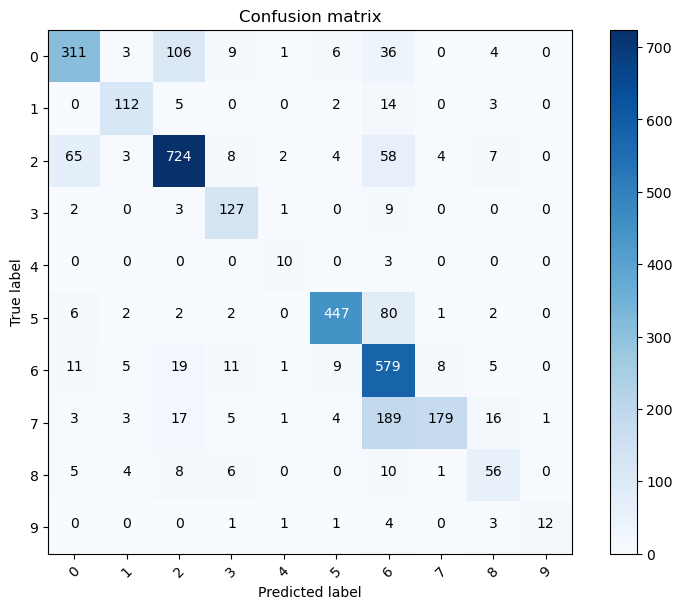

In [16]:
conf_matrix = confusion_matrix(val_labels, val_predictions)
print("Confusion Matrix:")
print(conf_matrix)

#Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(set(labels)))
plt.xticks(tick_marks, set(labels), rotation=45)
plt.yticks(tick_marks, set(labels))

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

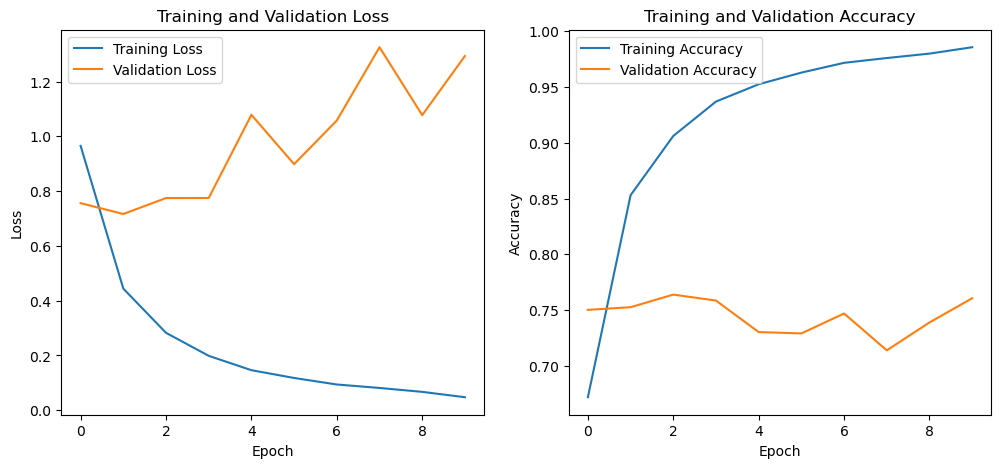

In [17]:
#Plot training loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [18]:
#Get accuracy of every class
class_accuracy = {}
for i in range(len(label_encoder.classes_)):
    class_name = label_encoder.classes_[i]
    total = conf_matrix[i].sum()
    correct = conf_matrix[i][i]
    accuracy = correct / total if total > 0 else 0.0
    class_accuracy[class_name] = accuracy

sorted_class_accuracy = sorted(class_accuracy.items(), key=lambda x: x[1], reverse=True)

print("Accuracy por clase:")
for class_name, acc in sorted_class_accuracy:
    print(f"{class_name}: {acc}")

# Calcular el accuracy general
accuracy = accuracy_score(val_labels, val_predictions)
print("Accuracy general:", accuracy)

Accuracy por clase:
fish aquatic pets: 0.8943661971830986
health care: 0.8935185185185185
dogs: 0.8274285714285714
hair care: 0.8247232472324724
diapering: 0.8235294117647058
fresh flowers live indoor plants: 0.7692307692307693
cats: 0.6533613445378151
safety: 0.6222222222222222
strollers: 0.5454545454545454
medical supplies equipment: 0.42822966507177035
Accuracy general: 0.7605591909577633


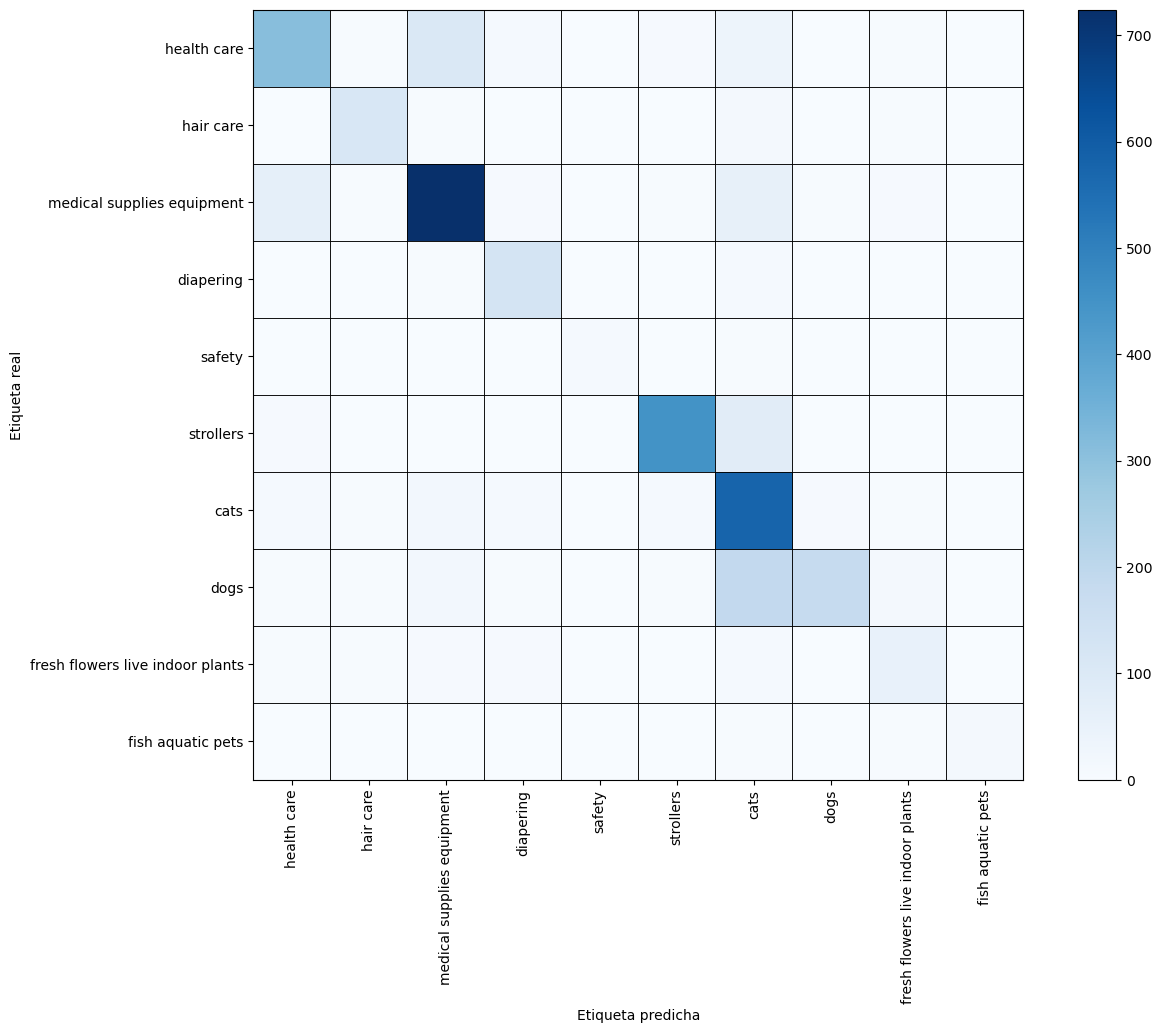

In [19]:
cmap=plt.cm.Blues

plt.figure(figsize=(14, 10))
plt.title("")

plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
plt.colorbar()
tick_marks = np.arange(num_labels)
plt.xticks(tick_marks, original_labels, rotation=90)
plt.yticks(tick_marks, original_labels)

for i in range(num_labels):
        for j in range(num_labels):
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='black', fill=None, linewidth=0.5))

plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta real')
plt.show()

In [20]:
model.save("Models/"+name_model+"_model")

2024-04-23 07:11:54.479261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'attention_mask' with dtype int32 and shape [?,?]
	 [[{{node attention_mask}}]]
2024-04-23 07:11:56.205535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'attention_mask' with dtype int32 and shape [?,?]
	 [[{{node attention_mask}}]]
2024-04-23 07:11:56.345900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_ids_1' with dtype int32 and shape [?,?]
	 [[{{n

INFO:tensorflow:Assets written to: Models/bert-base-uncased_model/assets


INFO:tensorflow:Assets written to: Models/bert-base-uncased_model/assets
